In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

In [2]:
raw_data =pd.read_csv('epi_r.csv')
raw_data.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
raw_data.shape

(20052, 680)

In [4]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

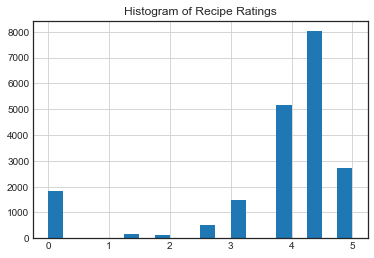

In [5]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

In [6]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]


calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

In [22]:
from sklearn.svm import SVR
svr = SVR()
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
Y = raw_data.rating
svr.fit(X,Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [23]:
svr.score(X, Y)

-0.017586634603904194

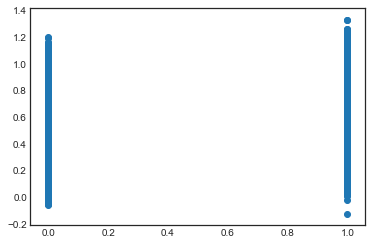

In [24]:
plt.scatter(Y, svr.predict(X))

In [25]:
from sklearn.model_selection import cross_val_score
cross_val_score(svr, X, Y, cv=5)

array([-0.07123898, -0.02733894, -0.07186814, -0.09328569, -0.0413374 ])

We can categorize the recipes in to two groups as good and bad or recommended and non recommended. We do so by assuming that people will not ignore recipes which have a rating of 4 or more and people will not be interested in the ones with a rating lower than 4. Let's drop the NaN values first. 

In [7]:
raw_data = raw_data.dropna()

In [8]:
# Running this line of code twice makes everything 0 !!!!!
raw_data['rating'] = (raw_data['rating'] >= 4).astype(int)

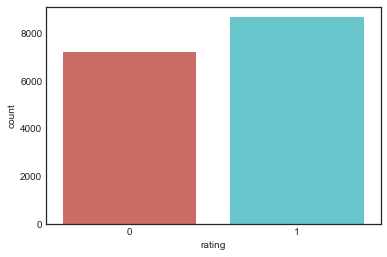

In [9]:
sns.countplot(x='rating', data=raw_data, palette='hls')
plt.show()

### Class imbalance 
The two classes have little difference in their value count and we could probably get away with ignoring it. But let's fix the imbalance anyways as it can only improve the model. (and for the sake of practicing)

In [10]:
raw_data['rating'].value_counts()

1    8658
0    7206
Name: rating, dtype: int64

In [14]:
#Import module for resampling 

from sklearn.utils import resample

# Separate majority and minority classes
raw_data_majority = raw_data[raw_data.rating==1]
raw_data_minority = raw_data[raw_data.rating==0]
 
# Downsample majority class
raw_data_majority_downsampled = resample(raw_data_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=7209,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
raw_data_resampled = pd.concat([raw_data_majority_downsampled, raw_data_minority])
 
# Display new class counts
print(raw_data_resampled.rating.value_counts())
print('We now have a sample with balanced class')

1    7209
0    7206
Name: rating, dtype: int64
We now have a sample with balanced class


In [ ]:
x and y

In [15]:
data = raw_data_resampled.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
target = raw_data_resampled.rating

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=0)

In [20]:
import time
start_time = time.clock()
from sklearn import svm
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
svc.fit(X_train, y_train)
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)

#pridict for the test set
Y_ = svc.predict(X_test)

#Confusion maxrix
from sklearn.metrics import confusion_matrix
cfm = confusion_matrix(y_test, Y_)
print('Confusion Matrix ridge')
print(cfm)

#Cross vlidation 
from sklearn.model_selection import cross_val_score
print(cross_val_score(svc, X_train, y_train, cv=5))
print("--- %s seconds ---" % (time.clock() - start_time))

#Classification report
from sklearn.metrics import classification_report
print('Classification report')
print(classification_report(y_test, Y_))

Confusion Matrix ridge
[[892 574]
 [636 781]]
[0.5752059  0.55916775 0.57285343 0.5793582  0.58889853]
--- 3201.683610453333 seconds ---
Classification report
             precision    recall  f1-score   support

          0       0.58      0.61      0.60      1466
          1       0.58      0.55      0.56      1417

avg / total       0.58      0.58      0.58      2883



In [21]:
3202/60


53.36666666666667

The model has improved from the original but still has poor accuracy and cross validation score. It also takes about 53 minutes to run which makes iterations time consuming. 